In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys

sys.path.append("..")

In [2]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm

In [3]:
import models.models_nn as nn
import models.models_classic_ml as cm
from data.create_datasets import WindowGenerator

In [4]:
df = pd.read_csv("../datasets/london_bike_sharing.csv")
data_name = 'london_bike_sharing'

In [5]:
df.set_index('timestamp', inplace=True)

In [6]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [7]:
# split data
n = len(df)
train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

In [8]:
# Normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Plot acf/pacf:

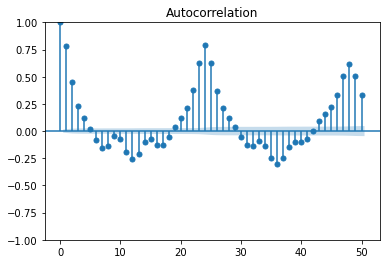

In [9]:
# to check important lags and seasonality
sm.graphics.tsa.plot_acf(df.cnt, lags=50)
plt.show()


### Data window

In [10]:
train_df.columns

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season'],
      dtype='object')

In [22]:
window = WindowGenerator(
    label_width=15,
    input_width=24,
    feature_columns= ['t1', 't2', 'hum', 'wind_speed', 'cnt'],
    label_columns= ['t1', 't2', 'hum', 'wind_speed', 'cnt'],
    shift=15,
)

In [23]:
window

Total window size: 39
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Label column name(s): ['t1', 't2', 'hum', 'wind_speed', 'cnt']
Feature column name (s): ['t1', 't2', 'hum', 'wind_speed', 'cnt']

In [24]:
inputs_train, labels_train = window.create_dataset(train_df)
inputs_val, labels_val = window.create_dataset(val_df)
inputs_test, labels_test = window.create_dataset(test_df)

### model: LSTM simple vector output

In [25]:
model = nn.LSTM_model_vec_out(window=window)

history = nn.compile_and_fit(
    model, X=inputs_train, y=labels_train, val_X=inputs_val, val_y=labels_val
)
IPython.display.clear_output()

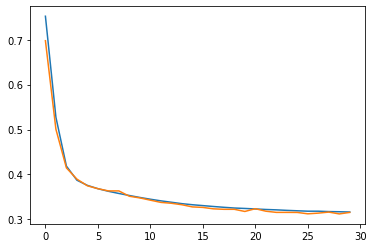

In [26]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")

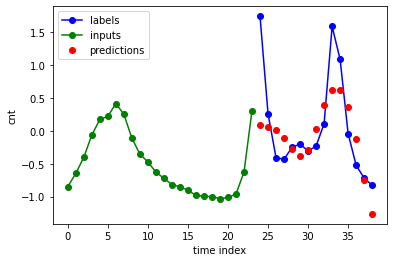

In [60]:
# plot one sample from test set
nn.plot_forecast(model, window=window, input_data=inputs_test, label_data= labels_test,
                          plot_col="cnt")

### predict future: LSTM built-in vector output

In [55]:
# the last sample in the test df or predicting future: vector output  
input_array = test_df[window.feature_columns].tail(window.input_width).to_numpy()
input_array = np.expand_dims(input_array, 0)
input_array.shape

(1, 24, 5)

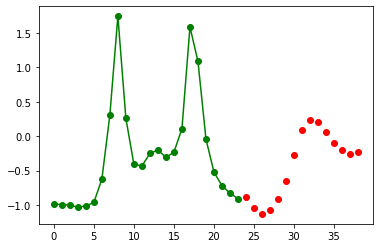

In [56]:
index_1 = window.feature_columns.index('cnt')
index_2 = window.label_columns.index('cnt')

plt.plot(window.input_indices, input_array[-1, :, index_1], "go-", label="inputs")
plt.plot(window.label_indices, model.predict(input_array)[-1, :, index_2], "ro", label="preds")

### predict future: LSTM Recurisive

In [42]:
# predicting future: Recursive forecast
recursive = nn.Recursive_Forecast(
output_time_step=15,
input_width=24,  
    feature_columns= ['t1', 't2', 'hum', 'wind_speed', 'cnt'],
    label_columns= ['t1', 't2', 'hum', 'wind_speed', 'cnt']
)
recursive.datasets(train_set=train_df, valid_set=val_df, test_set=test_df)
recursive.model_fit(nn.LSTM_model_vec_out)
IPython.display.clear_output()


In [52]:
preds = recursive.recursive_future(input_array)

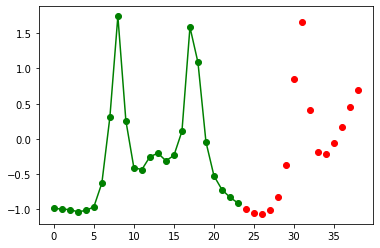

In [53]:
plt.plot(window.input_indices, input_array[-1, :, index_1], "go-", label="inputs")
plt.plot(window.label_indices, preds[-1, :, index_2], "ro", label="preds")

### predict future: LSTM Direct

In [54]:
# predicting future: Direct forecast
direct = nn.Direct_Forecast(
output_time_step=15,
input_width=24,  
    feature_columns= ['t1', 't2', 'hum', 'wind_speed', 'cnt'],
    label_columns= ['t1', 't2', 'hum', 'wind_speed', 'cnt']
)
direct.datasets(train_set=train_df, valid_set=val_df, test_set=test_df)
direct.model_fit(nn.LSTM_model_vec_out)
IPython.display.clear_output()

In [58]:
preds = direct.direct_future(input_array)

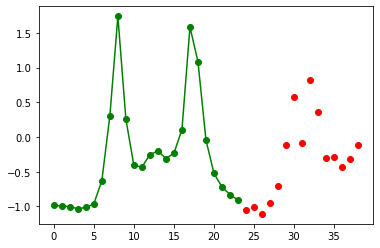

In [59]:
plt.plot(window.input_indices, input_array[-1, :, index_1], "go-", label="inputs")
plt.plot(window.label_indices, preds[-1, :, index_2], "ro", label="preds")